In [1]:
import csv
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import random

%matplotlib inline


In [2]:
train = pd.read_csv("data/titanic train.csv")
test = pd.read_csv("data/titanic test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Remove unwanted features

In [4]:
train.groupby("Survived")["PassengerId"].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,447.016393,260.640469,1.0,211.00,455.0,675.0,891.0
1,342.0,444.368421,252.358840,2.0,250.75,439.5,651.5,890.0


In [5]:
train = train.drop(["Name", 'Ticket', 'Cabin'], axis=1)
test = test.drop(["Name", 'Ticket', 'Cabin'], axis=1)

## Fill in missing values 1

#### Fare

In [6]:
train[train["Fare"].isna()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


In [7]:
test[test["Fare"].isna()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,male,60.5,0,0,NaN,S


In [8]:
test["Fare"] = test["Fare"].fillna(train["Fare"].median())

#### Embarked

In [9]:
train[train["Embarked"].isna()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1,1,female,38.0,0,0,80.0,NaN
829,830,1,1,female,62.0,0,0,80.0,NaN


In [10]:
test[test["Embarked"].isna()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


In [11]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [12]:
train["Embarked"] = train["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].fillna("S")

## Convert categorical variables to numeric form

In [13]:
train["Embarked"] = train["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
test["Embarked"] = test["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)

In [14]:
train["Sex"] = train["Sex"].map({"female":0, "male":1}).astype(int)
test["Sex"] = test["Sex"].map({"female":0, "male":1}).astype(int)

## Fill in missing values 2

#### Age (based on Pclass and Sex)

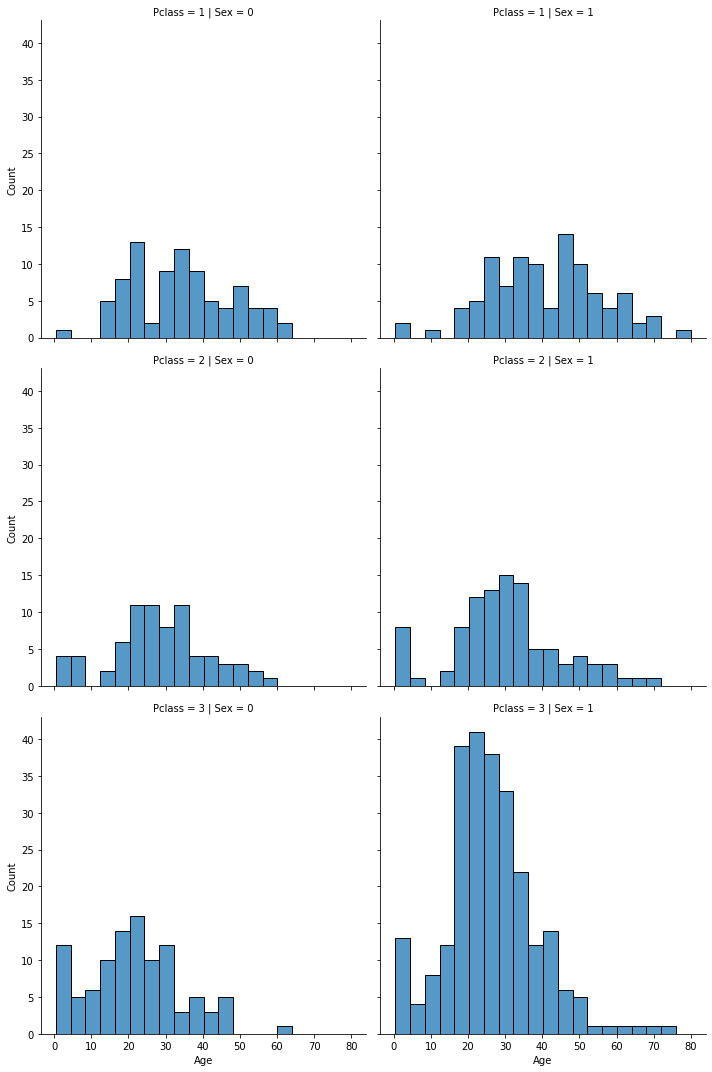

In [15]:
sns.displot(data=train, x="Age", row="Pclass", col="Sex");

In [18]:
# Guess of ages based on [Sex, Pclass]
guess_ages = np.zeros((2,3))

# Generate guesses based on training set
for sex in range(2):
    for pclass in range(3):
        guess = train[(train['Sex'] == sex) & \
                      (train['Pclass'] == pclass+1)]['Age'].dropna().median()
        guess_ages[sex, pclass] = guess

guess_ages = guess_ages.astype(int)

# Fill in missing values for both training and test sets
for sex in range(2):
    for pclass in range(3):
        train.loc[(train["Age"].isnull()) & (train["Sex"] == sex) \
              & (train["Pclass"] == pclass + 1), "Age"] = guess_ages[sex, pclass]
        
        test.loc[(test["Age"].isnull()) & (test["Sex"] == sex) \
              & (test["Pclass"] == pclass + 1), "Age"] = guess_ages[sex, pclass]

#### Sanity check

In [19]:
train.isna().value_counts()

PassengerId  Survived  Pclass  Sex    Age    SibSp  Parch  Fare   Embarked
False        False     False   False  False  False  False  False  False       891
dtype: int64

In [20]:
test.isna().value_counts()

PassengerId  Pclass  Sex    Age    SibSp  Parch  Fare   Embarked
False        False   False  False  False  False  False  False       418
dtype: int64

## Convert continuous variables to categorical

#### Age

In [21]:
train.loc[train["Age"] <= 10, "Age"] = 0
train.loc[(10 < train["Age"]) & (train["Age"] <= 20) , "Age"] = 1
train.loc[(20 < train["Age"]) & (train["Age"] <= 30) , "Age"] = 2
train.loc[(30 < train["Age"]) & (train["Age"] <= 40) , "Age"] = 3
train.loc[(40 < train["Age"]) & (train["Age"] <= 50) , "Age"] = 4
train.loc[(50 < train["Age"]) & (train["Age"] <= 60) , "Age"] = 5
train.loc[(60 < train["Age"]) & (train["Age"] <= 70) , "Age"] = 6
train.loc[(70 < train["Age"]) & (train["Age"] <= 80) , "Age"] = 7
train.loc[train["Age"] > 90 , "Age"] = 8

test.loc[test["Age"] <= 10, "Age"] = 0
test.loc[(10 < test["Age"]) & (test["Age"] <= 20) , "Age"] = 1
test.loc[(20 < test["Age"]) & (test["Age"] <= 30) , "Age"] = 2
test.loc[(30 < test["Age"]) & (test["Age"] <= 40) , "Age"] = 3
test.loc[(40 < test["Age"]) & (test["Age"] <= 50) , "Age"] = 4
test.loc[(50 < test["Age"]) & (test["Age"] <= 60) , "Age"] = 5
test.loc[(60 < test["Age"]) & (test["Age"] <= 70) , "Age"] = 6
test.loc[(70 < test["Age"]) & (test["Age"] <= 80) , "Age"] = 7
test.loc[test["Age"] > 90 , "Age"] = 8

#### Fare

In [22]:
train["FareBand"] = pd.qcut(train['Fare'], 10)
train.groupby("FareBand", as_index=False)["Survived"].mean()

,FareBand,Survived
0,"(-0.001, 7.55]",0.141304
1,"(7.55, 7.854]",0.298851
2,"(7.854, 8.05]",0.179245
3,"(8.05, 10.5]",0.230769
4,"(10.5, 14.454]",0.428571
5,"(14.454, 21.679]",0.420455
6,"(21.679, 27.0]",0.516854
7,"(27.0, 39.688]",0.373626
8,"(39.688, 77.958]",0.528090
9,"(77.958, 512.329]",0.758621


In [23]:
train.loc[train["Fare"] <= 7.55, "Fare"] = 1
train.loc[(7.55< train["Fare"]) & (train["Fare"] <=  7.854), "Fare"] = 2
train.loc[(7.854 < train["Fare"]) & (train["Fare"] <= 8.05), "Fare"] = 3
train.loc[(8.05 < train["Fare"]) & (train["Fare"] <= 10.5), "Fare"] = 4
train.loc[(10.5 < train["Fare"]) & (train["Fare"] <= 14.454), "Fare"] = 5
train.loc[(14.454 < train["Fare"]) & (train["Fare"] <= 21.679), "Fare"] = 6
train.loc[(21.679 < train["Fare"]) & (train["Fare"] <= 27.0), "Fare"] = 7
train.loc[(27.0 < train["Fare"]) & (train["Fare"] <= 39.688), "Fare"] = 8
train.loc[(39.688 < train["Fare"]) & (train["Fare"] <= 77.958), "Fare"] = 9
train.loc[(77.958 < train["Fare"]), "Fare"] = 10

test.loc[test["Fare"] <= 7.55, "Fare"] = 1
test.loc[(7.55< test["Fare"]) & (test["Fare"] <=  7.854), "Fare"] = 2
test.loc[(7.854 < test["Fare"]) & (test["Fare"] <= 8.05), "Fare"] = 3
test.loc[(8.05 < test["Fare"]) & (test["Fare"] <= 10.5), "Fare"] = 4
test.loc[(10.5 < test["Fare"]) & (test["Fare"] <= 14.454), "Fare"] = 5
test.loc[(14.454 < test["Fare"]) & (test["Fare"] <= 21.679), "Fare"] = 6
test.loc[(21.679 < test["Fare"]) & (test["Fare"] <= 27.0), "Fare"] = 7
test.loc[(27.0 < test["Fare"]) & (test["Fare"] <= 39.688), "Fare"] = 8
test.loc[(39.688 < test["Fare"]) & (test["Fare"] <= 77.958), "Fare"] = 9
test.loc[(77.958 < test["Fare"]), "Fare"] = 10

In [24]:
train.drop("FareBand", axis=1, inplace=True)

## Make new features

#### Age * Pclass

In [25]:
train["Age_Pclass"] = train["Age"] * train["Pclass"]
test["Age_Pclass"] = test["Age"] * test["Pclass"]

## Visualise the data

#### Survival by sex

In [26]:
sex_train = train[["Sex", "Survived"]].groupby("Sex", as_index=False).mean()
sex_train

,Sex,Survived
0,0,0.742038
1,1,0.188908


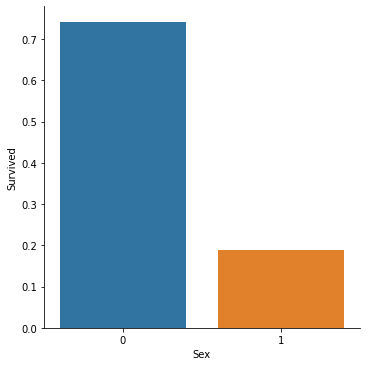

In [27]:
sns.catplot(data=sex_train, x="Sex", y="Survived", kind="bar");

#### Survival by Pclass

In [28]:
pclass_train = pd.DataFrame(train.groupby("Pclass")["Survived"].mean()).reset_index()
pclass_train


,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


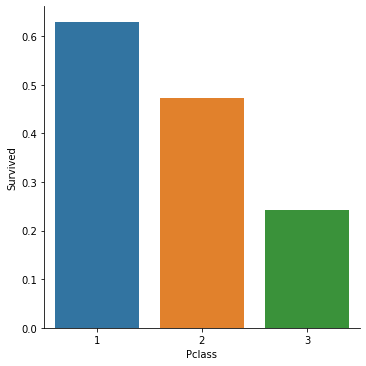

In [29]:
sns.catplot(data=pclass_train, x="Pclass", y="Survived", kind="bar");

#### Survival by Pclass and age

In [30]:
age_train = train[["Age", "Survived"]]
age_train.head()

,Age,Survived
0,2.0,0
1,3.0,1
2,2.0,1
3,3.0,1
4,3.0,0


In [31]:
age_train.groupby("Survived")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,2.422587,1.298483,0.0,2.0,2.0,3.0,7.0
1,342.0,2.295322,1.351845,0.0,2.0,2.0,3.0,7.0


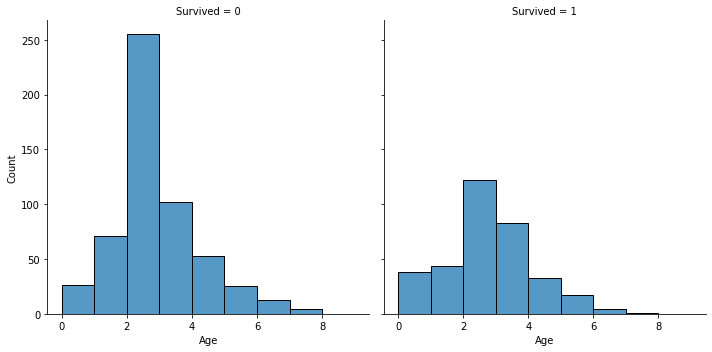

In [32]:
bins = np.arange(0, 10)
sns.displot(data=age_train, x="Age", bins=bins, col="Survived");

In [33]:
rel_train = train[["Age", "Sex", "Pclass", "Survived"]]
rel_train

,Age,Sex,Pclass,Survived
0,2.0,1,3,0
1,3.0,0,1,1
2,2.0,0,3,1
3,3.0,0,1,1
4,3.0,1,3,0
...,...,...,...,...
886,2.0,1,2,0
887,1.0,0,1,1
888,2.0,0,3,0
889,2.0,1,1,1


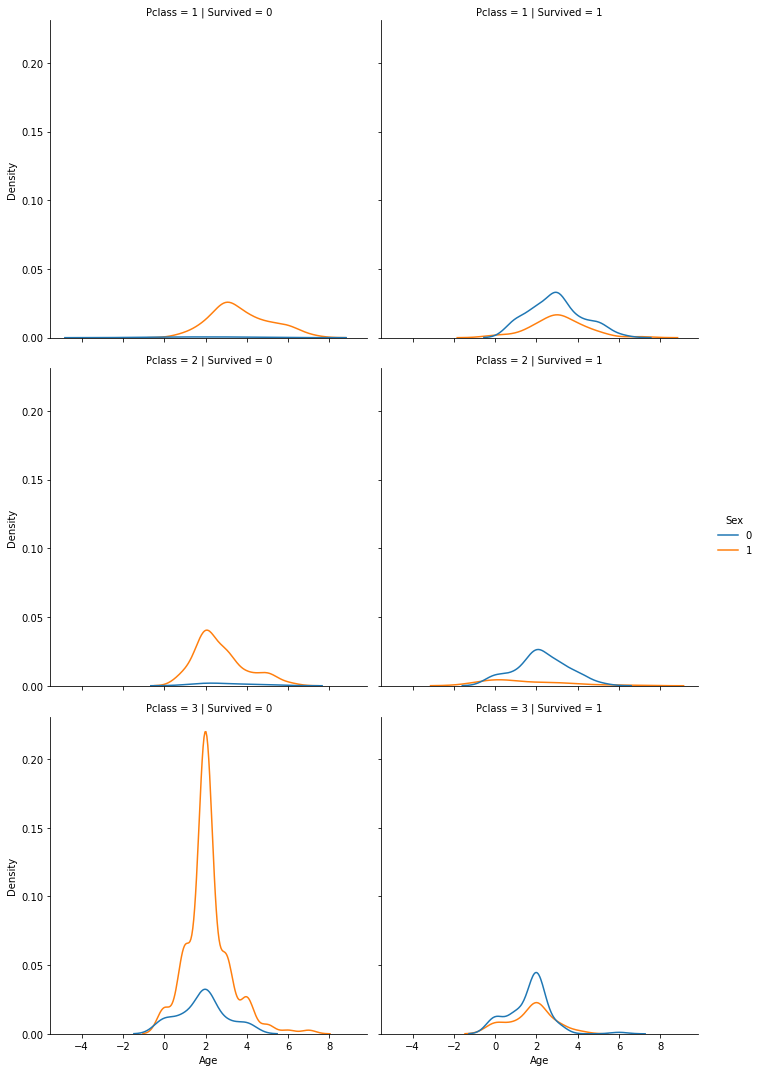

In [34]:
sns.displot(data=rel_train, x="Age", row="Pclass", 
            col="Survived", hue="Sex", kind="kde");

#### Survival by family size

In [35]:
train["Fam"] = train["SibSp"] + train["Parch"]
test["Fam"] = test["SibSp"] + test["Parch"]

train.drop(["SibSp", "Parch"], axis=1, inplace=True)
test.drop(["SibSp", "Parch"], axis=1, inplace=True)

train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Age_Pclass,Fam
0,1,0,3,1,2.0,1.0,0,6.0,1
1,2,1,1,0,3.0,9.0,1,3.0,1
2,3,1,3,0,2.0,3.0,0,6.0,0
3,4,1,1,0,3.0,9.0,0,3.0,1
4,5,0,3,1,3.0,3.0,0,9.0,0


In [36]:
fam_train = train[["Fam", "Survived"]].sort_values(by="Fam")
fam_train_survived = fam_train[fam_train["Survived"] == 1].value_counts()
fam_train_no_survived = fam_train[fam_train["Survived"] == 0].value_counts()

In [37]:
# remove redundant "survived" column
fam_train_survived = fam_train_survived.loc[:, 1]
fam_train_no_survived = fam_train_no_survived.loc[:, 0]

fam_train_survived.sort_index(inplace=True)
fam_train_no_survived.sort_index(inplace=True)

fam_train_survived = fam_train_survived.reset_index()
fam_train_no_survived = fam_train_no_survived.reset_index()

fam_train_survived.columns = ["Fam", "Count"]
fam_train_no_survived.columns = ["Fam", "Count"]

fam_train_survived["Survived"] = 1
fam_train_no_survived["Survived"] = 0

fam_train = pd.concat([fam_train_survived, fam_train_no_survived])

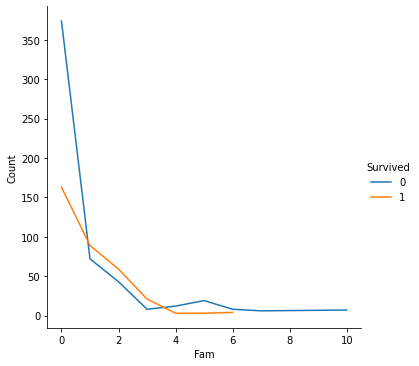

In [38]:
sns.relplot(data=fam_train, x="Fam", y="Count", hue="Survived", kind="line");

#### Correlation between features

In [210]:
train_plot = train.drop("PassengerId", axis=1)

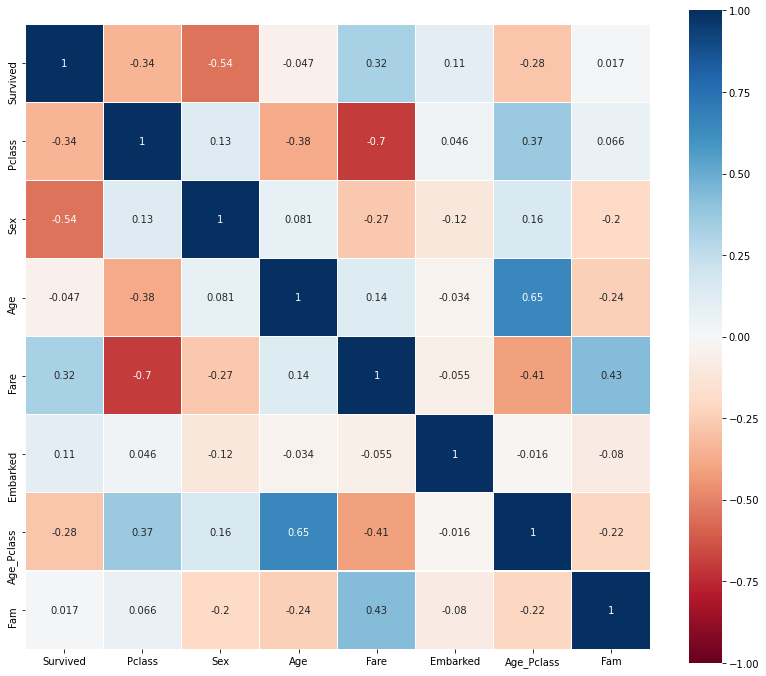

In [215]:
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(train_plot.corr(), ax=ax, square=True, cmap="RdBu",
            linecolor="white", linewidths=0.1, vmin=-1, annot=True);

## Modelling the data

#### PassengerId = index + 1

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(["Survived", "PassengerId"], axis=1), 
                                                    train.loc[:, "Survived"],
                                                    random_state=1)

In [75]:
X_train

,Pclass,Sex,Age,Fare,Embarked,Age_Pclass,Fam
35,1,1,4.0,9.0,0,4.0,1
46,3,1,2.0,6.0,2,6.0,1
453,1,1,4.0,10.0,1,4.0,1
291,1,0,1.0,10.0,1,1.0,1
748,1,1,1.0,9.0,0,1.0,1
...,...,...,...,...,...,...,...
715,3,1,1.0,2.0,0,3.0,0
767,3,0,3.0,2.0,2,9.0,0
72,2,1,2.0,9.0,0,4.0,0
235,3,0,2.0,1.0,0,6.0,0


#### Stochastic Gradient Descent

In [187]:
from sklearn.linear_model import SGDClassifier
sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)
sgd_model.score(X_test, y_test)

0.7802690582959642

#### Logistic Regression

In [188]:
from sklearn.linear_model import LogisticRegression
logr_model = LogisticRegression()
logr_model.fit(X_train, y_train)
logr_model.score(X_test, y_test)

0.7937219730941704

#### GaussianNB

In [189]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_model.score(X_test, y_test)

0.7757847533632287

#### SVM (SLOW)

In [122]:
from sklearn.svm import SVC
svm_model = SVC(kernel="linear", C=1E10)
# svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)

#### KNN

In [226]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)

0.757847533632287

Optimal number of neighbors seems to be in the 5-7 range

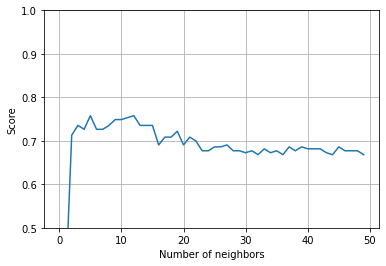

In [232]:
scores = np.zeros([50, 2])
for i in range(2, 50):
    scores[i] = [i, KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train).score(X_test, y_test)]

fig, ax = plt.subplots()
ax.plot(scores[:, 0], scores[:, 1])
ax.set(ylim=(0.5, 1.0), xlabel="Number of neighbors", ylabel="Score")
ax.grid();

#### Descision tree

In [193]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier()
dtree_model.fit(X_train, y_train)
dtree_model.score(X_test, y_test)

0.757847533632287

#### Random Forest

In [235]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.7757847533632287

As we can see below, the number of estimators doesn't really play a big part in accuracy in this case.

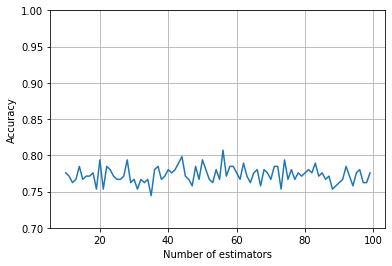

In [238]:
scores = np.zeros([190, 2])
for i in range(10, 100):
    scores[i] = [i, RandomForestClassifier(n_estimators=i).fit(X_train, y_train).score(X_test, y_test)]

fig, ax = plt.subplots()
ax.plot(scores[10:100, 0], scores[10:100, 1])
ax.set(ylim=(0.7, 1.0), xlabel="Number of estimators", ylabel="Accuracy")
ax.grid();